In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import cloudscraper
import os
import sys
import sqlite3
import datetime
import json
import bs4
import time
from sklearn.metrics import r2_score
import talib
import tensorflow as tf
import itertools
import re
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib
import yfinance as yf
import logging
import copy

tf.get_logger().setLevel(logging.ERROR)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
DATA2_PATH = './data2'
DATA1_PATH = './data'
DATA3_PATH = './data3'
DB_PATH = 'idx_data_v1.db'
CORRELATION_JSON = './stocks_correlation.json'
FAVORITE_STOCK = './favorite_stocks.json'
FAVORITE_STOCK_MY = './favorite_stocks_MY.json'
FAVORITE_STOCK_DY = './favorite_stocks_DY.json'

In [2]:
def stock_list_100_highestrank_and_availability():
    '''Return a list of idx stock that have
    highest availability and most popular.
    Algorithm:
    - Get 150 stock with highest data availability
    - From stock filtered above, get 100 most popular
        stock (by relative idx volume rank)
    '''
    tickers = ['BBRI', 'BUMI', 'ELTY', 'TLKM', 'BRPT', 'LPKR', 'BKSL', 'BMRI', 'KLBF', 'BTEK', 'ASRI', 'KIJA', 'FREN', 'ANTM', 'ASII', 'ADRO', 'MEDC', 'BHIT', 'PWON', 'PNLF', 'BNII', 'PTBA', 'TINS', 'ELSA', 'MLPL', 'DOID', 'KREN', 'CNKO', 'CTRA', 'META', 'ENRG', 'SMRA', 'MDLN', 'BBNI', 'APIC', 'BMTR', 'LSIP', 'MAPI', 'BSDE', 'INDF', 'BBKP', 'MNCN', 'CPIN', 'WIKA', 'BNBR', 'SSIA', 'BNGA', 'BEKS', 'ADHI', 'RAJA', 'DILD', 'BBCA', 'PBRX', 'DGIK', 'PNBN', 'INDY', 'ACES', 'MYOR', 'INCO', 'AKRA', 'TBLA', 'KPIG', 'GZCO', 'TOTL', 'UNVR', 'INKP', 'SMCB', 'MPPA', 'GJTL', 'INTA', 'JSMR', 'HMSP', 'CMNP', 'MASA', 'SRSN', 'BNLI', 'INAF', 'RALS', 'ADMG', 'UNTR', 'SCMA', 'ISAT', 'DSFI', 'BDMN', 'MTDL', 'SULI', 'TURI', 'SMGR', 'TMAS', 'MAIN', 'KAEF', 'EXCL', 'SMSM', 'LPPS', 'POLY', 'KBLI', 'UNSP', 'PKPK', 'BUDI', 'CSAP']
    return tickers

def yfinance_db(stock_db='idx_raw.db', if_exists='replace'):
    '''Fetch data from yfinance and store
    it into defined stock_db.
    '''
    stocks_db_conn = sqlite3.connect(stock_db)
    tickers = stock_list_100_highestrank_and_availability()
    
    count=0
    for ticker in tickers:     
        # Fetch and store data
        stock_object = yf.Ticker(f'{ticker}.JK')
        df = stock_object.history(period='max')
        df = df.reset_index()
        df['Date'] = df['Date'].apply(lambda x: x.value)
        df = df.drop(['Dividends', 'Stock Splits'], axis='columns')
        df = df.rename(columns={'Date':'time','Open':'open','High':'high','Low':'low','Close':'close'})
        df.to_sql(name=ticker, con=stocks_db_conn, index=False, if_exists=if_exists)
        print(f'{count} {ticker}')
        count+=1
        time.sleep(2)

def stock_metadata():
    '''Fetch available (traded)
    stock reference.
    '''
    # Read investing metadata
    metadata_conn = sqlite3.connect('./investing_data.db', timeout=10)

    sql = f'select * from metadata'
    investing_metadata = pd.read_sql(sql, metadata_conn)
    return investing_metadata
      
def calculate_stock_volume_contribution(origin_db, target_db):
    '''Calculate ratio of traded stock volume
    for each day compared to IDX total volume
    in each day.
    
    Store calculated ratio in new table 'IDX'
    '''
    origin_db_conn = sqlite3.connect(origin_db)
    target_db_conn = sqlite3.connect(target_db)

    investing_metadata = stock_metadata()
    
    # Delete all df variables that exists
    try:
        del df
    except NameError:
        pass

    for index in range(len(investing_metadata)):
        ticker1 = investing_metadata.loc[index]['ticker']
        df1 = pd.read_sql(f'select time, Volume from {ticker1}', origin_db_conn)

        try:
            df = df.merge(df1, how='outer')
            df = df.rename(columns={'Volume':ticker1})
        except NameError:
            df = df1.copy(deep=True)
            df = df.rename(columns={'Volume':ticker1})

    # Calculate stock volume
    df_volume = df.copy(deep=True)
    df_volume = df.drop('time', axis='columns')
    df_volume = df_volume.fillna(0)
    df_volume['IDX'] = df_volume.sum(axis=1)

    # df_volume
    df['IDX'] = df_volume['IDX']
    df = df.sort_values(by='time')

    # Calculate the stock volume relative to total volume
    for index in range(len(investing_metadata)):
        ticker1 = investing_metadata.loc[index]['ticker']
        df[f'{ticker1}_'] = df[ticker1] / df['IDX']

    # Drop stock traded volume
    df = df.drop(investing_metadata['ticker'], axis='columns')
    
    # Drop row that has zero sum of volumes
    df = df[df.IDX != 0.0]

    # Save dataframe into database
    df.to_sql(name='IDX', con=target_db_conn, index=False, if_exists='replace')
        
def calculate_EMA(df, column, emas=(3,10,30,200)):
    for ema in emas:
        df[f'{column}_EMA{ema}'] = df[column].ewm(span=ema, adjust=False).mean()
    return df

# Old version
# calculate gradient from 4 samples
def calculate_EMA_gradient(df, column, emas=(3,10,30,200)):
    for ema in emas:
        multiplier = [1, 1/2, 3/4, 7/8]
        samples = [int(m * ema) for m in multiplier]
        sample_columns = []
        for i, sample in enumerate(samples):
            sample_column_name = f'{column}_EMA{ema}_G{i}'
            sample_columns.append(sample_column_name)
            df[sample_column_name] = (df[f'{column}_EMA{ema}'] - df[f'{column}_EMA{ema}'].shift(sample)) / ema
        df[f'{column}_EMA{ema}_G'] = df.loc[:, sample_columns].sum(axis=1) / len(samples)
        df = df.drop(sample_columns, axis='columns')
    return df

# Revised version
# Calculate gradient from tn-1 only
def calculate_EMA_gradient(df, column, emas=(3,10,30,200)):
    for ema in emas:
        df[f'{column}_EMA{ema}_G'] = df[f'{column}_EMA{ema}'] - df[f'{column}_EMA{ema}'].shift(1)
    return df

def calculate_signal_EMA_offset(df, column, signal=3, emas=(10,30,200)):
    signal_column = f'{column}_EMA{signal}'
    for ema in emas:
        source_column = f'{column}_EMA{ema}'
        target_column = f'{column}_EMA{signal}_EMA{ema}_offset'
        df[target_column] = (df[signal_column] - df[source_column]) / df[source_column]
    return df

def calculate_candle_score(df, columns=('open','high','low','close','change')):
    open_c, high_c, low_c, close_c, change_c = columns
    candle_I0, candle_I1, candle_I2, candle_I3, candle_I4, candle_I5 = ('candle_I0', 'candle_I1', 'candle_I2', 'candle_I3', 'candle_I4', 'candle_I5')
    candle_S1, candle_S2, candle_S3, candle_S4 = ('candle_S1', 'candle_S2', 'candle_S3', 'candle_S4')
    
    # Candle body
    df[candle_I0] = df[open_c] - df[close_c]
    
    # Identify red / green candle status
    df[candle_I1] = np.select([df[candle_I0] < 0, df[candle_I0] > 0, df[candle_I0].isna()],
                              [-1, 1, np.nan], default=0)
    
    # High-low range, relative to close price
    df[candle_I2] = (df[high_c] - df[low_c]) / df[close_c]
    
    # Absolute relative body length to close price
    df[candle_I3] = (df[candle_I0] / df[close_c]).abs()
    
    # Body length / high-low range ratio
    df[candle_I4] = df[candle_I3] / df[candle_I2]
    
    # Candle body offset relative to high-low mean
    df[candle_I5] = ((((df[high_c] - df[low_c]) / 2) + 
                      ((df[close_c] - df[open_c]) / 2)) / 
                     ((df[high_c] - df[low_c]) / 2))
        
    # Score1: product of I1 * sum of I2-I5
    df[candle_S1] = df[candle_I1] * (df[candle_I2] + df[candle_I3] + df[candle_I4] + df[candle_I5])
    
    # Score2: product of I1 * average if I2-I5
    df[candle_S2] = df[candle_I1] * (df[candle_I2] + df[candle_I3] + df[candle_I4] + df[candle_I5]) / 4
    
    # Score3: product of I1-I5
    df[candle_S3] = df[candle_I1] * df[candle_I2] * df[candle_I3] * df[candle_I4] * df[candle_I5]
    
    # Score4: product of I1 * absolute of I2-I5 product
    df[candle_S4] = df[candle_I1] * (df[candle_I2] * df[candle_I3] * df[candle_I4] * df[candle_I5]).abs()
    
    return df
    
def calculate_favorite_stock(FAVORITE_STOCK, threshold=20, column_groups=('day', 'month', 'year')):
    '''day-month-year favorite
    FAVORITE_STOCK: string, path to save the results.
    '''
    stocks_db_conn = sqlite3.connect(DB_PATH)
    df_IDX = pd.read_sql('select * from IDX', stocks_db_conn)

    # Convert integer timestamp into date
    df_IDX['time'] = pd.to_datetime(df_IDX['time'])

    # Make new column for year/month/day
    df_IDX.loc[:,'year'] = df_IDX['time'].dt.year
    df_IDX.loc[:,'month'] = df_IDX['time'].dt.month
    df_IDX.loc[:,'day'] = df_IDX['time'].dt.day

    # Drop time column to avoid interference to the rank
    df_IDX_rank = df_IDX.drop(['time','IDX','day','month','year'], axis='columns')

    # Calculate rank
    df_IDX_rank = df_IDX_rank.rank(axis=1, ascending=True)

    # Normalize rank
    df_IDX_rank = df_IDX_rank.apply(lambda x: x / df_IDX_rank.count(axis=1))

    all_results = {}
    for column_group in column_groups:
        groups_result = {}
        for group_value in df_IDX[column_group].unique():
            tick = datetime.datetime.now()

            # Calculate rank for every specified range
            df_IDX_filtered = df_IDX.loc[df_IDX[column_group] == group_value]
            record_length = len(df_IDX_filtered)
            
            group_result = {}
            weight = np.arange(1, threshold+1)[::-1] / record_length

            # Loop through selected index
            for index in df_IDX_filtered.index:
                top_tickers = df_IDX_rank.iloc[index].sort_values(ascending=False)[:threshold].index


                for i, top_ticker in enumerate(top_tickers):
                    if top_ticker in group_result:
                        group_result[top_ticker] = group_result[top_ticker] + weight[i]
                    else:
                        group_result[top_ticker] = weight[i]

            groups_result[str(group_value)] = group_result

            tock = datetime.datetime.now()
            print(f'{str(column_group)} - {group_value}')

        all_results[column_group] = groups_result
        with open(FAVORITE_STOCK, 'w') as f:
            json.dump(all_results, f)
            
def calculate_favorite_stockv2(FAVORITE_STOCK, threshold=20, main_group='year', sub_group='day'):
    '''day-year / month-year
    FAVORITE_STOCK: string, path to save the results.
    '''
    stocks_db_conn = sqlite3.connect(DB_PATH)
    df_IDX = pd.read_sql('select * from IDX', stocks_db_conn)

    # Convert integer timestamp into date
    df_IDX['time'] = pd.to_datetime(df_IDX['time'])

    # Make new column for year/month/day
    df_IDX.loc[:,'year'] = df_IDX['time'].dt.year
    df_IDX.loc[:,'month'] = df_IDX['time'].dt.month
    df_IDX.loc[:,'day'] = df_IDX['time'].dt.day

    # Drop time column to avoid interference to the rank
    df_IDX_rank = df_IDX.drop(['time','IDX','day','month','year'], axis='columns')

    # Calculate rank
    df_IDX_rank = df_IDX_rank.rank(axis=1, ascending=True)

    # Normalize rank
    df_IDX_rank = df_IDX_rank.apply(lambda x: x / df_IDX_rank.count(axis=1))

    groups_result = {}
    for main_value in df_IDX[main_group].unique():
        for sub_value in df_IDX[sub_group].unique():
            tick = datetime.datetime.now()

            # Calculate rank for every specified range
            df_IDX_filtered = df_IDX.loc[(df_IDX[main_group] == main_value) & (df_IDX[sub_group] == sub_value)]
            record_length = len(df_IDX_filtered)

            group_result = {}
            weight = np.arange(1, threshold+1)[::-1] / record_length

            # Loop through selected index
            for index in df_IDX_filtered.index:
                top_tickers = df_IDX_rank.iloc[index].sort_values(ascending=False)[:threshold].index

                for i, top_ticker in enumerate(top_tickers):
                    if top_ticker in group_result:
                        group_result[top_ticker] = group_result[top_ticker] + weight[i]
                    else:
                        group_result[top_ticker] = weight[i]

            groups_result[f"{main_value}_{f'0{sub_value}' if sub_value < 10 else f'{sub_value}'}"] = group_result

            tock = datetime.datetime.now()
            print(f'{main_value} - {sub_value}')

            with open(FAVORITE_STOCK, 'w') as f:
                json.dump(groups_result, f)
                
def calculate_horizontal_support_resistance(stocks_db_conn, ticker, indicators):
    '''
    ticker: string
    indicator: dict
    '''
    dfhs = pd.read_sql(f'select * from {ticker}', stocks_db_conn)
    
    sr_lines = {}
    # Calculate horizontal support/resistance lines
    for indicator in indicators:
        # Stack multiple column to single column
        dfhs_sliced = dfhs[indicators[indicator]]
        try:
            bins = int(len(dfhs_sliced.stack()) / 10)

            # Calculate histogram intervals
            x = pd.cut(dfhs_sliced.stack(), bins).value_counts()
        except ValueError:
            bins = len(dfhs_sliced.stack())

            # Calculate histogram intervals
            x = pd.cut(dfhs_sliced.stack(), bins).value_counts()

        # Calculate middle value of interval and store to new df
        mid_values = []
        for mid in x.index:
            mid_values.append((mid.mid, x[mid]))
        hist_pd = pd.DataFrame(mid_values)

        # Filter horizontal s/r lines that has less than mean frequency
        sr_line_df = hist_pd.loc[hist_pd[1] <= hist_pd[1].mean()].sort_values(by=0)
        sr_line_df = sr_line_df.reset_index(drop=True)

        # Get 10 s/r lines with same range between them
        sr_thresholds = np.linspace(0,1,10)
        calculated_sr = []
        for sr_threshold in sr_thresholds:
            calculated_sr.append(sr_line_df.iloc[int((len(sr_line_df) - 1) * sr_threshold)][0])
        sr_lines[indicator] = calculated_sr
    return sr_lines

def __comp__calculate_stock_change_ratio(df, shift=1):
    '''Calculate stock change in %.
    Default shift value is 1, meaning that
    it's calculating daily stock price change.    
    '''
    df['change'] = (df['close'] - df['close'].shift(shift)) / df['close'].shift(shift)
    return df

def __comp__calculate_stock_volume_rank(df, df_IDX_rank, ticker):
    '''Calculate stock volume rank from `IDX` table
    and insert it into individual stock table
    '''
    df = df.merge(df_IDX_rank[['time', f'{ticker}_']], how='inner')
    df = df.rename(columns={f'{ticker}_':'Volume_rank'})
    return df

def __comp__calculate_stock_indicator(df):
    source_columns = ['close', 'rsi14', 'Volume', 'Volume_rank', 'change']
    df['rsi14'] = talib.RSI(df['close'], timeperiod=14)
    df = calculate_candle_score(df)
    for source_column in source_columns:
        df = calculate_EMA(df, source_column)
        df = calculate_EMA_gradient(df, source_column)
        df = calculate_signal_EMA_offset(df, source_column)
    return df

def __comp__calculate_oscillation_between_sr(df, origin_db_conn, ticker):
    indicators = {'close':['open','high','low','close'],'rsi14':['rsi14'],'Volume':['Volume'],'Volume_rank':['Volume_rank'],'change':['change']}
    sr_lines = calculate_horizontal_support_resistance(stocks_db_conn, ticker, indicators)

    # Calculate indicator progress between interval
    for indicator in indicators:
        # Define condition and choice list
        condlist = [df[indicator] <= sr for sr in sr_lines[indicator][1:]]
        choicelist_t = [sr for sr in sr_lines[indicator][1:]]
        choicelist_b = [sr for sr in sr_lines[indicator][:len(sr_lines[indicator]) - 1]]
        df[f'{indicator}_b'] = np.select(condlist, choicelist_b, default=choicelist_b[-1])
        df[f'{indicator}_t'] = np.select(condlist, choicelist_t, default=choicelist_t[-1])

        # Calculate progress between interval.
        # *basically, just min/max norm between bottom/top interval
        df[f'{indicator}_srp'] = (df[indicator] - df[f'{indicator}_b']) / (df[f'{indicator}_t'] - df[f'{indicator}_b'])
        df = df.drop([f'{indicator}_b',f'{indicator}_t'], axis='columns')

    # Add close price relative to all time low / high
    df['close_rel'] = (df['close'] - df['close'].min()) / df['close'].max()
    return df

def __comp__calculate_cumulative_change(df):
    '''Calculate price change f_shift ahead from
    previous day.
    '''
    f_shifts=(3,5,7,10)
    b_shifts = [1 for _ in range(len(f_shifts))]
    for i, f_shift in enumerate(f_shifts):
        b_shift = b_shifts[i]
        df[f'change_b{b_shift}f{f_shift}'] = (df['close'].shift(-f_shift) - df['close'].shift(b_shift)) / df['close'].shift(b_shift)
    return df

def __comp__calculate_forecast_column(df):
    '''Calculate close_EMA3_G and close_EMA10_G
    at +1 and +2 forecast
    '''
    columns_to_forecast = ('close_EMA3_G','close_EMA10_G')
    forecast_lengths = (1,2)
    for column_to_forecast in columns_to_forecast:
        for forecast_length in forecast_lengths:
            df[f'{column_to_forecast}_s{forecast_length}'] = df[column_to_forecast].shift(-forecast_length)
    return df

def calculate_all_indicator(origin_db, target_db, verbose=1, selected_stock_only=False):
    origin_db_conn = sqlite3.connect(origin_db)
    target_db_conn = sqlite3.connect(target_db)
    investing_metadata = stock_metadata()
    count = 0
    
    # calculate_stock_volume_contribution
    # Calculate ratio of traded stock volume for
    # each day compared to IDX total volume each day
    calculate_stock_volume_contribution(origin_db, target_db)
    
    # Fetch calculated IDX rank data frame
    df_IDX_rank = _calculate_stock_volume_rank(stock_db)
    
    selected_stock = stock_list_100_highestrank_and_availability()
    
    for index in range(len(investing_metadata)):
        ticker = investing_metdata.loc[index]['ticker']
        
        if ticker not in selected_stock and selected_stock_only:
            continue    
        
        # Read origin stock data
        df = pd.read_sql(f'select * from {ticker}', origin_db_conn)
        
        # Some indicator calculation #
        # calculate_stock_change_ratio
        df = __comp__calculate_stock_change_ratio(df, shift=1)
        
        # calculate_stock_volume_rank
        # Merge volume rank into individual stock df
        df = __comp__calculate_stock_volume_rank(df, df_IDX_rank, ticker)
        
        # calculate_stock_indicator
        df = __comp__calculate_stock_indicator(df)
            
        # calculate_oscillation_between_sr
        df = __comp__calculate_oscillation_between_sr(df, origin_db_conn, ticker)
        
        # calculate_cumulative_change
        df = __comp__calculate_cumulative_change(df)
            
        # calculate_forecast_column
        df = __comp__calculate_forecast_column(df)     
        ##############################
        
        # Write back into table
        df.to_sql(name=ticker, con=target_db_conn, index=False, if_exists='replace')
        
        count+=1
        if verbose and count%50 == 0:
            print(f'Current progress: {count}/{len(investing_metadata)}')

In [ ]:
data3_insert_init(stock_db=DB_PATH, origin_data_path='./data3', verbose=1)

In [ ]:
# data2 database insert
columns = ('Date', 'Close', 'Volume')
columns_dtypes = ('integer', 'integer', 'integer')
unique_columns = ('Date',)
LOOP_LIMIT = None

# Create database connection
conn = sqlite3.connect(DB_PATH, timeout=10)
cur = conn.cursor()

data_lists = os.listdir(DATA2_PATH)

count = 0
for stock_fname in data_lists:
    stock_name = stock_fname[:4]
    source_path = f'{DATA2_PATH}/{stock_fname}'

    # Fetch data from source
    data_insert_lists = data2_data_insert_lists(source_path, columns=columns)

    # Create a new table
    create_table(cur, stock_name, columns, columns_dtypes, unique_columns, verbose=1)
    
    # Insert data into table
    insert_data_to_table(conn, cur, stock_name, data_insert_lists, verbose=1)
    
    count+=1
    
    if count == LOOP_LIMIT:
        break

In [ ]:
calculate_stock_change_ratio(DB_PATH, verbose=1)

# The most popular stock for traders over time

In [70]:
calculate_stock_volume_contribution(stock_db=DB_PATH)

# Calculate stock volume rank

In [329]:
calculate_stock_volume_rank(DB_PATH)

# Calculate stock indicator

In [513]:
calculate_stock_indicator(stock_db)

## Manual run/analysis

In [801]:
ticker = 'BBRI'
DB_PATH = f'./idx_data_v1.2.db' # add cumulative price change
excluded_columns_re = 'change_b.f.'
epochs = (15,)
lstmus = (14,)
recurrents = (50,)
output_c = 'close_EMA3_G'
input_c = ['change','change_EMA3','change_EMA3_G','close_EMA3_EMA200_offset','close_srp','rsi14_EMA3_EMA30_offset','Volume_rank_EMA3','close_EMA10','candle_S3','Volume_rank_EMA10']
train = 0.90

# For machine learning
excluded_columns = ['time','open','high','low','close']

# Load data
stocks_db_conn = sqlite3.connect(DB_PATH)
df = pd.read_sql(f'select * from {ticker}', stocks_db_conn)
df = df.drop(excluded_columns, axis='columns')
df = df.fillna(0)

# Train/test split
train_df = df[:int(train*len(df))]
test_df = df[int(train*len(df)):]
test_df.reset_index(inplace=True, drop=True)

train_mean = train_df.mean()
train_std = train_df.std()

# Normalize dataset
train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

for recurrent in recurrents:
    for lstmu in lstmus:
        for epoch in epochs:
            # Make dataset
            train_dataset = TimeseriesGenerator(train_df[input_c], train_df[output_c], length=recurrent, shuffle=False)
            test_dataset = TimeseriesGenerator(test_df[input_c], test_df[output_c], length=recurrent)

            # LSTM Model
            lstm_model = tf.keras.models.Sequential([
                tf.keras.layers.GRU(lstmu, return_sequences=False),
                tf.keras.layers.Dense(1),
            ])

            # Compiling model
            lstm_model.compile(optimizer='adam',
                            loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

            # Feed and train the model
            lstm_model.fit(train_dataset, epochs=epoch, verbose=0)

            # Evaluate model
            train_eval = lstm_model.evaluate(train_dataset, verbose=0)
            test_eval = lstm_model.evaluate(test_dataset, verbose=0)

            print(f'''R[{recurrent}] LU[{lstmu}] E[{epoch}] trainRMSE[{round(train_eval[1], 4)}] testRMSE[{round(test_eval[1], 4)}]''')    

R[50] LU[14] E[15] trainRMSE[0.6075] testRMSE[1.615]


# Manual model evaluation

In [802]:
# Evaluate model accuracy
# prediction_model = tf.keras.Sequential([lstm_model])
train_predictions = lstm_model.predict(train_dataset)
test_predictions = lstm_model.predict(test_dataset)

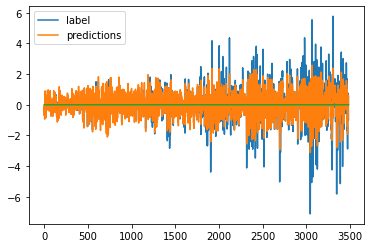

In [806]:
diff_length = train_df[output_c].shape[0] - train_predictions.shape[0]
plt.plot(train_df[output_c][diff_length:].values, label='label')
plt.plot(train_predictions[:], label='predictions')
plt.plot(np.arange(1, len(train_predictions)+1, 1), np.zeros_like(train_predictions))
# plt.xlim([800,1000])
plt.legend()
plt.show()

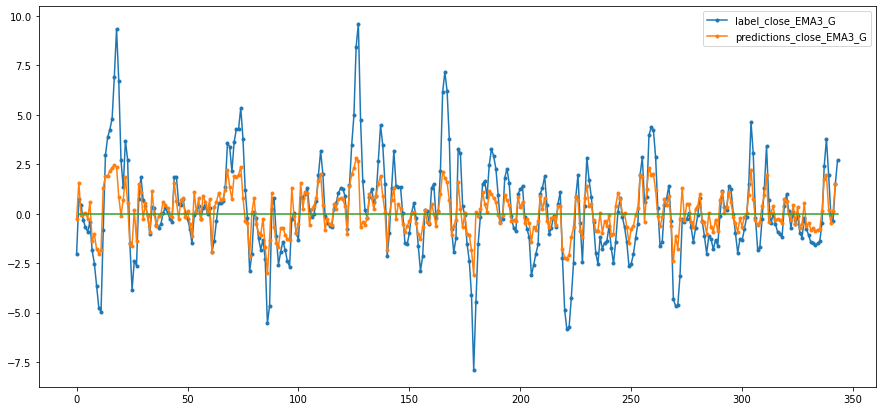

In [807]:
plt.figure(figsize=(15,7))
diff_length = test_df[output_c].shape[0] - test_predictions.shape[0]
plt.plot(test_df[output_c][diff_length-1:].values, label=f'label_{output_c}', marker=matplotlib.markers.MarkerStyle('.'))
plt.plot(test_predictions, label=f'predictions_{output_c}', marker=matplotlib.markers.MarkerStyle('.'))

# plt.plot(test_df['close_EMA3_EMA10_offset'][diff_length-1:].values, label='close_EMA3_EMA10_offset', marker=matplotlib.markers.MarkerStyle('.'))
# plt.plot(test_df['change_EMA10'][diff_length-1:].values, label='change_EMA10', marker=matplotlib.markers.MarkerStyle('.'))
# plt.plot(test_df['close_EMA10_G'][diff_length-1:].values, label='close_EMA10_G', marker=matplotlib.markers.MarkerStyle('.'))
# plt.plot(test_df['close_EMA3_G'][diff_length-1:].values, label='close_EMA3_G', marker=matplotlib.markers.MarkerStyle('.'))
# plt.plot(test_df['change'][diff_length-1:].values, label='change', marker=matplotlib.markers.MarkerStyle('.'))

plt.plot(np.arange(1, len(test_predictions)+1, 1), np.zeros_like(test_predictions))
# plt.xlim([800,1000])
# plt.xlim([200,300])
# plt.xlim([200,400])
# plt.xlim([200,300])
# plt.xlim([400,500])
# plt.ylim([-7,7])
plt.legend()
plt.show()

# Stock with highest correlation

In [6]:
with open(CORRELATION_JSON, 'r') as f:
    stock_correlation = json.loads(f.read())
    
# Replace all diagonal with NaN
for key1 in stock_correlation.keys():
    stock_correlation[key1][key1] = np.nan
    
df_sc = pd.DataFrame(stock_correlation)

df_sc_desc = df_sc.describe().T
df_sc_desc.sort_values(by='min', ascending=False)[::-1]

# Top 10 stock for further analyis
- Rank top 50 stock by data availability
- Rank those stock by average stock rank
- Get top 10

In [29]:
stocks_db_conn = sqlite3.connect(DB_PATH)
tsdf = pd.read_sql('select * from IDX', stocks_db_conn)
tsdf = tsdf.drop(['time','IDX'], axis='columns')

# Count total available trading days
tsdf_count = tsdf.count(axis=0)
tsdf_count = tsdf_count.sort_values(ascending=False)[:150]

# Sort by highest rank
tsdf_rank = tsdf[tsdf_count.index]
tsdf_rank = tsdf_rank.mean(axis=0)
tsdf_rank = tsdf_rank.sort_values(ascending=False)

# Sort by lowest rank standar deviation
tsdf_std = tsdf[tsdf_count.index]
tsdf_std = tsdf_std.std(axis=0)
tsdf_std = tsdf_std.sort_values(ascending=True)

# Result of top 5 higest rank + top 5 lowest rank std
top10 = ['BBRI','TLKM','LPKR','BMRI','KLBF','GGRM','AALI','INTP','BDMN','UNVR']
top20 = ['ANTM','ASII','MEDC','PTBA','TINS','UNTR','ISAT','INCO','GJTL','ADHI'] # SMCB replaced by ADHI
top30 = ['CTRA','LSIP','INDF','INKP','PNLF','BRPT','BBCA','AKRA','BBNI','TSPC']

In [32]:
print([x.replace('_', '') for x in tsdf_rank[:100].index])

['BBRI', 'BUMI', 'ELTY', 'TLKM', 'BRPT', 'LPKR', 'BKSL', 'BMRI', 'KLBF', 'BTEK', 'ASRI', 'KIJA', 'FREN', 'ANTM', 'ASII', 'ADRO', 'MEDC', 'BHIT', 'PWON', 'PNLF', 'BNII', 'PTBA', 'TINS', 'ELSA', 'MLPL', 'DOID', 'KREN', 'CNKO', 'CTRA', 'META', 'ENRG', 'SMRA', 'MDLN', 'BBNI', 'APIC', 'BMTR', 'LSIP', 'MAPI', 'BSDE', 'INDF', 'BBKP', 'MNCN', 'CPIN', 'WIKA', 'BNBR', 'SSIA', 'BNGA', 'BEKS', 'ADHI', 'RAJA', 'DILD', 'BBCA', 'PBRX', 'DGIK', 'PNBN', 'INDY', 'ACES', 'MYOR', 'INCO', 'AKRA', 'TBLA', 'KPIG', 'GZCO', 'TOTL', 'UNVR', 'INKP', 'SMCB', 'MPPA', 'GJTL', 'INTA', 'JSMR', 'HMSP', 'CMNP', 'MASA', 'SRSN', 'BNLI', 'INAF', 'RALS', 'ADMG', 'UNTR', 'SCMA', 'ISAT', 'DSFI', 'BDMN', 'MTDL', 'SULI', 'TURI', 'SMGR', 'TMAS', 'MAIN', 'KAEF', 'EXCL', 'SMSM', 'LPPS', 'POLY', 'KBLI', 'UNSP', 'PKPK', 'BUDI', 'CSAP']


# Rank 20 most popular stock / month / year / month-year
check month-year & day-year formula & calculation steps. 
add month-year & day-year

add by week-year

```python
# Loop through every date
# Sort by rank
# Weight stock by rank
# Sum those score for every stock in some extent(for ex: every month/year/month-year)
# Get top 20 stock in some interval

# For visualization: convert ticker into number, and do shading.
```

In [ ]:
calculate_favorite_stockv2(FAVORITE_STOCK_MY, threshold=20, main_group='year', sub_group='month')
calculate_favorite_stockv2(FAVORITE_STOCK_DY, threshold=20, main_group='year', sub_group='day')

In [948]:
with open(FAVORITE_STOCK, 'r') as f:
    favorite_stock = json.loads(f.read())
favorite_stock.keys()

dict_keys(['day', 'month', 'year'])

In [ ]:
dffs_month = pd.DataFrame(favorite_stock['month'])
dffs_month = dffs_month.reindex([str(x) for x in sorted([int(x) for x in dffs_month.columns])], axis=1)
dffs_month.sort_values('1', ascending=False)[:20].style.background_gradient(cmap='Blues', axis=1)

In [ ]:
threshold = 50
dffs_year = pd.DataFrame(favorite_stock['year'])
dffs_year = dffs_year.reindex([str(x) for x in sorted([int(x) for x in dffs_year.columns])], axis=1)
dffs_year.sort_values('2020', ascending=False)[:threshold].style.background_gradient(cmap='Blues', axis=1)

In [1008]:
with open(FAVORITE_STOCK_DY, 'r') as f:
    favorite_stock_DY = json.loads(f.read())
dffs_DY = pd.DataFrame(favorite_stock_DY)
dffs_DY = dffs_DY.reindex(sorted(dffs_DY.columns), axis=1)

In [ ]:
threshold = 20
dffs_DY.filter(regex=('2021.*')).sort_values(by='2021_13', ascending=False)[:threshold].style.background_gradient(axis=1)

In [1011]:
with open(FAVORITE_STOCK_MY, 'r') as f:
    favorite_stock_MY = json.loads(f.read())
dffs_MY = pd.DataFrame(favorite_stock_MY)
dffs_MY = dffs_DY.reindex(sorted(dffs_MY.columns), axis=1)

In [ ]:
threshold = 20
dffs_MY
# dffs_MY.filter(regex=('2021.*')).sort_values(by='2021_13', ascending=False)[:threshold].style.background_gradient(axis=1)

# Horizontal support/resistance

```python
# How to automatically assign high histogram value in different region?
```

In [ ]:
calculate_oscillation_between_sr(DB_PATH)

# Cumulative change

In [32]:
calculate_cumulative_change(DB_PATH, f_shifts=(3,5,7,10))

# Add close_EMA3_G & close_EMA10_G shift(-1)

In [863]:
calculate_forecast_column(DB_PATH)

# Results visualization

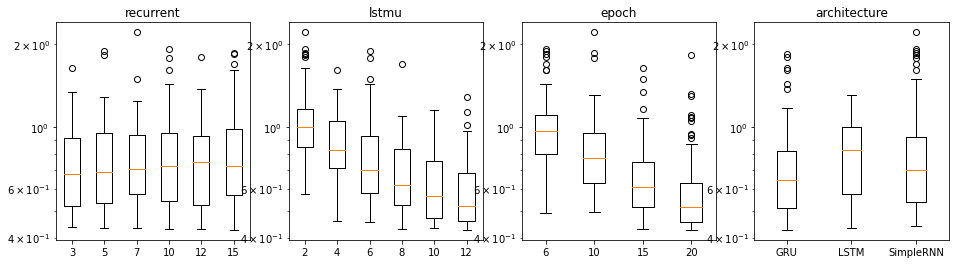

In [957]:
ROOT_PATH = './'
sa_seq = '6'
ticker = 'INTP'
output_c = 'close_EMA3_G'
filename = f'stock_sa{sa_seq}_{ticker}_{output_c}.csv'
# filename = f'stock_sa{sa_seq}_{ticker}.csv'

columns = ('ticker','input_c','output_c','recurrent','lstmu','epoch','train_mse','train_rmse','test_mse','test_rmse')
columns = ('ticker','input_c','output_c','architecture','recurrent','lstmu','epoch','train_mse','train_rmse','test_mse','test_rmse')

sa_DF = pd.read_csv(f'{ROOT_PATH}statistics/{filename}', header=0, names=columns)

# Visualization of different parameters sensitivity
plot_scale = 4
plot_value = 'test_mse'
plot_columns = ('recurrent','lstmu','epoch','architecture')
plots = [sorted(sa_DF[plot_column].unique()) for plot_column in plot_columns]

fig, ax = plt.subplots(1, len(plots), figsize=(4 * len(plots), 4))
for i, plot in enumerate(plots):
    plot_data = []
    for j, plot_key in enumerate(plots[i]):
        data = sa_DF.loc[sa_DF[plot_columns[i]] == plot_key]
        plot_data.append(data[plot_value].values)
    ax[i].boxplot(plot_data)
    ax[i].set_title(plot_columns[i])
    ax[i].set_xticklabels(plot)
    ax[i].set_yscale('log')

In [958]:
sa_DF.sort_values(by='test_rmse')

,ticker,input_c,output_c,architecture,recurrent,lstmu,epoch,train_mse,train_rmse,test_mse,test_rmse
286,INTP,close_EMA3_G|change_EMA3_EMA10_offset|Volume_E...,close_EMA3_G,GRU,15,12,20,0.302161,0.549691,0.426185,0.652828
254,INTP,close_EMA3_G|change_EMA3_EMA10_offset|Volume_E...,close_EMA3_G,GRU,12,8,20,0.310517,0.557240,0.430143,0.655853
237,INTP,close_EMA3_G|change_EMA3_EMA10_offset|Volume_E...,close_EMA3_G,GRU,10,12,15,0.336542,0.580123,0.430375,0.656029
278,INTP,close_EMA3_G|change_EMA3_EMA10_offset|Volume_E...,close_EMA3_G,GRU,15,8,20,0.312553,0.559064,0.432718,0.657813
282,INTP,close_EMA3_G|change_EMA3_EMA10_offset|Volume_E...,close_EMA3_G,GRU,15,10,20,0.311658,0.558264,0.432803,0.657878
...,...,...,...,...,...,...,...,...,...,...,...
263,INTP,close_EMA3_G|change_EMA3_EMA10_offset|Volume_E...,close_EMA3_G,GRU,15,2,6,1.457013,1.207068,1.832920,1.353854
120,INTP,close_EMA3_G|change_EMA3_EMA10_offset|Volume_E...,close_EMA3_G,SimpleRNN,15,2,10,1.458535,1.207698,1.853529,1.361444
31,INTP,close_EMA3_G|change_EMA3_EMA10_offset|Volume_E...,close_EMA3_G,SimpleRNN,5,6,6,1.430978,1.196235,1.886022,1.373325
71,INTP,close_EMA3_G|change_EMA3_EMA10_offset|Volume_E...,close_EMA3_G,SimpleRNN,10,2,6,1.534783,1.238864,1.922985,1.386717


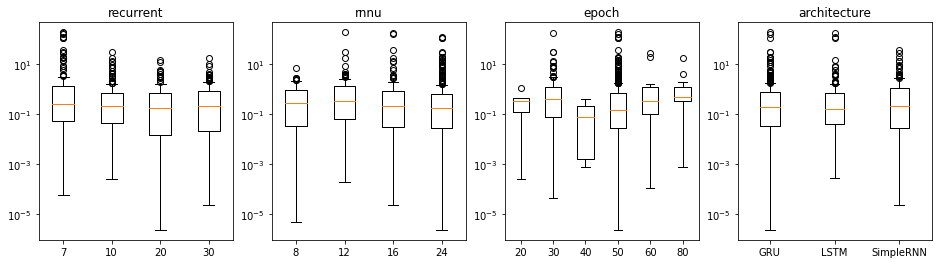

In [20]:
sa_DF = statistics_df
# Visualization of different parameters sensitivity
plot_scale = 4
plot_value = 'test_mse'
plot_columns = ('recurrent','rnnu','epoch','architecture')
plots = [sorted(sa_DF[plot_column].unique()) for plot_column in plot_columns]

fig, ax = plt.subplots(1, len(plots), figsize=(4 * len(plots), 4))
for i, plot in enumerate(plots):
    plot_data = []
    for j, plot_key in enumerate(plots[i]):
        data = sa_DF.loc[sa_DF[plot_columns[i]] == plot_key]
        plot_data.append(data[plot_value].values)
    ax[i].boxplot(plot_data)
    ax[i].set_title(plot_columns[i])
    ax[i].set_xticklabels(plot)
    ax[i].set_yscale('log')

# input_c sensitivity analysis
- sa5 for +1
- sa7 for +2
- sa9 for +3
- etc.

# Model configuration optimization
- sa6 for +1
- sa8 for +2
- sa10 for +3
- etc.

In [3]:
import tensorflow as tf
import sqlite3
import datetime
import pandas as pd
import re
from keras.preprocessing.sequence import TimeseriesGenerator
import json
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# # Google colab modules
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# ROOT_PATH = './gdrive/MyDrive/#PROJECT/idx/'

def stock_list_100_highestrank_and_availability():
    '''Return a list of idx stock that have
    highest availability and most popular.
    Algorithm:
    - Get 150 stock with highest data availability
    - From stock filtered above, get 100 most popular
        stock (by relative idx volume rank)
    '''
    tickers = ['BBRI', 'BUMI', 'ELTY', 'TLKM', 'BRPT', 'LPKR', 'BKSL', 'BMRI', 'KLBF', 'BTEK', 'ASRI', 'KIJA', 'FREN', 'ANTM', 'ASII', 'ADRO', 'MEDC', 'BHIT', 'PWON', 'PNLF', 'BNII', 'PTBA', 'TINS', 'ELSA', 'MLPL', 'DOID', 'KREN', 'CNKO', 'CTRA', 'META', 'ENRG', 'SMRA', 'MDLN', 'BBNI', 'APIC', 'BMTR', 'LSIP', 'MAPI', 'BSDE', 'INDF', 'BBKP', 'MNCN', 'CPIN', 'WIKA', 'BNBR', 'SSIA', 'BNGA', 'BEKS', 'ADHI', 'RAJA', 'DILD', 'BBCA', 'PBRX', 'DGIK', 'PNBN', 'INDY', 'ACES', 'MYOR', 'INCO', 'AKRA', 'TBLA', 'KPIG', 'GZCO', 'TOTL', 'UNVR', 'INKP', 'SMCB', 'MPPA', 'GJTL', 'INTA', 'JSMR', 'HMSP', 'CMNP', 'MASA', 'SRSN', 'BNLI', 'INAF', 'RALS', 'ADMG', 'UNTR', 'SCMA', 'ISAT', 'DSFI', 'BDMN', 'MTDL', 'SULI', 'TURI', 'SMGR', 'TMAS', 'MAIN', 'KAEF', 'EXCL', 'SMSM', 'LPPS', 'POLY', 'KBLI', 'UNSP', 'PKPK', 'BUDI', 'CSAP']
    return tickers

def stock_metadata(ROOT_PATH):
    '''Fetch available (traded)
    stock reference.
    '''
    # Read investing metadata
    metadata_conn = sqlite3.connect(f'{ROOT_PATH}investing_data.db', timeout=10)

    sql = f'select * from metadata'
    investing_metadata = pd.read_sql(sql, metadata_conn)
    return investing_metadata

def input_c_from_sa(ROOT_PATH, sa_seq, ticker, output_c):
    '''Fetch input_c list from
    sensitivity analysis file
    '''
    filename = f'stock_sa{sa_seq}_{ticker}_{output_c}.json'

    with open(f'{ROOT_PATH}statistics/{filename}', 'r') as f:
        sa_dict = json.load(f)

    final_column = sorted(sa_dict.items(), key=lambda x: x[1])[0][0]

    input_c = []
    for sa_key in sa_dict.keys():
        input_c.append(sa_key)
        if sa_key == final_column:
            break
    return input_c

def split_traintest(df, split=0.8):
    '''Splif df with train fraction.
    Normalize data using train set mean-std normalization.
    Return normalized train-test set, mean, and std.
    '''
    # Train/test split
    train_df = df[:int(split*len(df))]
    test_df = df[int(split*len(df)):]
    test_df.reset_index(inplace=True, drop=True)

    train_mean = train_df.mean()
    train_std = train_df.std()

    # Normalize dataset
    train_df = (train_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    return train_df, test_df, train_mean, train_std

def model_compiler(model):
    '''Adam optimizer, mse loss, RMSE metrics
    '''
    model.compile(optimizer='adam',
                  loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

def simpleRNN_1layer(units, return_sequences=False, create_input_layer=False, shape=None):
    if create_input_layer:
        model = tf.keras.models.Sequential([
            tf.keras.Input(shape),
            tf.keras.layers.SimpleRNN(units, return_sequences=return_sequences),
            tf.keras.layers.Dense(1),
        ])
    else:
        model = tf.keras.models.Sequential([
            tf.keras.layers.SimpleRNN(units, return_sequences=return_sequences),
            tf.keras.layers.Dense(1),
        ])
    return model_compiler(model)

def GRU_1layer(units, return_sequences=False, create_input_layer=False, shape=None):
    if create_input_layer:
        model = tf.keras.models.Sequential([
            tf.keras.Input(shape),
            tf.keras.layers.GRU(units, return_sequences=return_sequences),
            tf.keras.layers.Dense(1),
        ])
    else:
        model = tf.keras.models.Sequential([
            tf.keras.layers.GRU(units, return_sequences=return_sequences),
            tf.keras.layers.Dense(1),
        ])
    return model_compiler(model)

def LSTM_1layer(units, return_sequences=False, create_input_layer=False, shape=None):
    if create_input_layer:
        model = tf.keras.models.Sequential([
            tf.keras.Input(shape),
            tf.keras.layers.LSTM(units, return_sequences=return_sequences),
            tf.keras.layers.Dense(1),
        ])
    else:
        model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(units, return_sequences=return_sequences),
            tf.keras.layers.Dense(1),
        ])
    return model_compiler(model)    

def execute_input_c(offset, ticker, ROOT_PATH, output_c='close_EMA3_G', db_ver='1.3', input_c_limit=10, epochs=(15,), rnnus=(14,), recurrents=(7,), train=0.8):
    '''Performing sensitivity input_c sensitivity analysis
    that satisfies passed parameters
    '''
    sa_identifier = 5 + 2 * (offset - 1)
    DB_PATH = f'{ROOT_PATH}idx_data_v{db_ver}.db' # add cumulative price change
    excluded_columns_res = ('change_b.f.', '_s[0-9]*')
    if offset > 1:
        output_c = f'{output_c}_s{offset - 1}'
    STATISTICS_FILE = f'{ROOT_PATH}statistics/stock_sa{sa_identifier}_{ticker}_{output_c}.csv'

    # For machine learning
    excluded_columns = ['time','open','high','low','close']

    # Load data
    stocks_db_conn = sqlite3.connect(DB_PATH)
    df = pd.read_sql(f'select * from {ticker}', stocks_db_conn)
    df = df.drop(excluded_columns, axis='columns')
    df = df.fillna(0)
    
    train_df, test_df, train_mean, train_std = split_traintest(df, split=train)

    # Convert all possible input column into dictionary
    # as `additional_c`
    additional_c = [x for x in df.columns]

    # Delete columns that satisfy `excluded_columns_re`
    for excluded_columns_re in excluded_columns_res:
        additional_c = [x for x in additional_c if not re.search(excluded_columns_re, x)]

    # Replace csv with plain statistics file name
    sa_statistics = STATISTICS_FILE.replace('.csv', '')

    try:
        # Fetch `input_s` as hotstart
        # Loop through `additional_c`, and delete keys that have been simulated before
        # in `additional_c`. Using condition in `input_s.keys()`
        with open(f'{sa_statistics}.json', 'r') as f:
            input_s = json.load(f)

        # Delete `additional_c` that have been simulated before
        additional_c = [x for x in additional_c if x not in input_s.keys()]

    except FileNotFoundError:
        input_s = {}

    # Do a simulation as long as there are more `additional_c` to simulate
    # Loop through `additional_c` everytime, until no more left.
    # Better executed with while
    while len(additional_c) > 0 and len(input_s.keys()) < input_c_limit:
        # Use `additional_c_results` dictionary as `additional_c` sim results control. 
        # the format: {add_c: RMSE_performance}
        additional_c_results = {}

        current_ac_loop = 1
        for ac in additional_c:
            # Add additional simulated column into previous input order
            # input_c = [x for x in input_s.keys()]
            # input_c.append(ac)
            # This `input_c` resetted in every `additional_c` loop

            # Configure input column by adding +1 column to a previous
            # configuration to see how much the performance increasing
            input_c = [x for x in input_s.keys()]
            input_c.append(ac)

            for recurrent in recurrents:
                for rnnu in rnnus:
                    for epoch in epochs:
                        tick = datetime.datetime.now()

                        # Make dataset
                        train_dataset = TimeseriesGenerator(train_df[input_c], train_df[output_c], length=recurrent, shuffle=True)
                        test_dataset = TimeseriesGenerator(test_df[input_c], test_df[output_c], length=recurrent)

                        # RNN Model
                        model = GRU_1layer(rnnu, return_sequences=False)
                        
                        # Feed and train the model
                        model.fit(train_dataset, epochs=epoch, verbose=0)

                        # Evaluate model
                        train_eval = model.evaluate(train_dataset, verbose=0)
                        test_eval = model.evaluate(test_dataset, verbose=0)

                        input_c_joined = '|'.join(input_c)
                        statistics = f'''{ticker},{input_c_joined},{output_c},{recurrent},{lstmu},{epoch},{train_eval[0]},{train_eval[1]},{test_eval[0]},{test_eval[1]}\n'''
                        with open(STATISTICS_FILE, 'a') as f:
                            f.write(statistics)

                        tock = datetime.datetime.now()

                        print(f'''{ticker} i[{len(input_c)}] acleft[{current_ac_loop}/{len(additional_c)}] aic[{ac}] R[{recurrent}] LU[{lstmu}] E[{epoch}] trainRMSE[{round(train_eval[1], 4)}] testRMSE[{round(test_eval[1], 4)}] time: {tock-tick}''')
                        current_ac_loop+=1

                        # Add testRMSE into `additional_c_results`
                        additional_c_results[ac] = test_eval[1]

        # Everytime the loop through `additional_c` finish,
        # sort the `additional_c_results` using
        # max_res = sorted(additional_c_results.items(), keys=lambda x: x[1])
        max_res = sorted(additional_c_results.items(), key=lambda x: x[1])

        # Fetch max_res[0] to `input_s`
        # input_s[max_res[0][0]] = max_res[0][1]
        input_s[max_res[0][0]] = max_res[0][1]

        # Everytime the SA period finish, the most sensitive
        # additional column deleted from `additional_c`
        additional_c.remove(max_res[0][0])

        print(f'=== MOST SENSITIVE: {max_res[0][0]} with combined RMSE: {max_res[0][1]} ===')

        # Save current `input_s` to file
        with open(f'{sa_statistics}.json', 'w') as f:
            json.dump(input_s, f)
            
def execute_configuration_optimization(offset, ticker, ROOT_PATH, output_c='close_EMA3_G', db_ver='1.3', epochs=(10,20,40), rnnus=(4,8,12,16), recurrents=(5,7,10,15,20), train=0.8):
    architectures = ('SimpleRNN', 'GRU', 'LSTM')
    sa_identifier = 6 + 2 * (offset - 1)
    DB_PATH = f'{ROOT_PATH}idx_data_v{db_ver}.db' # add cumulative price change
    excluded_columns_res = ('change_b.f.', '_s[0-9]*')
    if offset > 1:
        output_c = f'{output_c}_s{offset - 1}'
    STATISTICS_FILE = f'{ROOT_PATH}statistics/stock_sa{sa_identifier}_{ticker}_{output_c}.csv'
    input_c = input_c_from_sa(ROOT_PATH, sa_identifier-1, ticker, output_c)

    # For machine learning
    excluded_columns = ['time','open','high','low','close']

    # Load data
    stocks_db_conn = sqlite3.connect(DB_PATH)
    df = pd.read_sql(f'select * from {ticker}', stocks_db_conn)
    df = df.drop(excluded_columns, axis='columns')
    df = df.fillna(0)
    
    # Split and normalize train-test set
    train_df, test_df, train_mean, train_std = split_traintest(df, split=train)
    
    # Create progress cache
    progress_cache_file = f'{ROOT_PATH}progress_cache/opt_{offset}_{ticker}_{output_c}.txt'
    try:
        with open(progress_cache_file, 'r') as f:
            HOTSTART = int(f.read())
    except FileNotFoundError:
        HOTSTART = 0

    loops = 0
    for architecture in architectures:
        for recurrent in recurrents:
            for rnnu in rnnus:
                for epoch in epochs:
                    tick = datetime.datetime.now()
                    # Hotstart
                    if loops < HOTSTART:
                        loops+=1
                        continue

                    # Make dataset
                    train_dataset = TimeseriesGenerator(train_df[input_c], train_df[output_c], length=recurrent, shuffle=True)
                    test_dataset = TimeseriesGenerator(test_df[input_c], test_df[output_c], length=recurrent)

                    # RNN Model
                    if architecture == 'SimpleRNN':
                        model = simpleRNN_1layer(rnnu, return_sequences=False)
                    elif architecture == 'GRU':
                        model = GRU_1layer(rnnu, return_sequences=False)
                    elif architecture == 'LSTM':
                        model = LSTM_1layer(rnnu, return_sequences=False)

                    # Feed and train the model
                    model.fit(train_dataset, epochs=epoch, verbose=0)

                    # Evaluate model
                    train_eval = model.evaluate(train_dataset, verbose=0)
                    test_eval = model.evaluate(test_dataset, verbose=0)

                    input_c_joined = '|'.join(input_c)
                    statistics = f'''{ticker},{input_c_joined},{output_c},{architecture},{recurrent},{lstmu},{epoch},{train_eval[0]},{train_eval[1]},{test_eval[0]},{test_eval[1]}\n'''
                    with open(STATISTICS_FILE, 'a') as f:
                        f.write(statistics)

                    tock = datetime.datetime.now()

                    print(f'''{loops} {ticker} {len(input_c)} {architecture} R[{recurrent}] LU[{lstmu}] E[{epoch}] trainRMSE[{round(train_eval[1], 5)}] testRMSE[{round(test_eval[1], 5)}] time: {tock-tick}''')

                    loops+=1
                    # Save progress to cache
                    with open(progress_cache_file, 'w') as f:
                        f.write(str(loops))
            
def execute_batch(simtype, offset, instance_no, ROOT_PATH, split=5, output_cs=('close_EMA3_G','close_EMA10_G'), db_ver='1.3', input_c_limit=4, epochs=(10,), rnnus=(14,), recurrents=(5,), train=0.8):
    '''
    type: string
        input_c
        opt
    '''
    # Create progress cache
    progress_cache_file = f'{ROOT_PATH}progress_cache/{simtype}_{offset}_{instance_no}.txt'
    try:
        with open(progress_cache_file, 'r') as f:
            HOTSTART = int(f.read())
    except FileNotFoundError:
        HOTSTART = 0
    
    # Fetch stock metadata
    # investing_metadata = stock_metadata(ROOT_PATH)
    tickers = stock_list_100_highestrank_and_availability()
    
    # Total batch per instances
    batch = int(len(tickers) / split)
    
    batch_metadata = tickers[instance_no * batch:(instance_no + 1) * batch]
    
    loops = 0
    for ticker in batch_metadata:
        for output_c in output_cs:
            # Hotstart
            if loops < HOTSTART:
                loops+=1
                continue
            if simtype == 'input_c':
                execute_input_c(offset, ticker, ROOT_PATH, output_c, db_ver, input_c_limit, epochs, rnnus, recurrents, train)
            elif simtype == 'opt':
                execute_configuration_optimization(offset, ticker, ROOT_PATH, output_c, db_ver, epochs, rnnus, recurrents, train)
            loops+=1
            
            # Save progress to cache
            with open(progress_cache_file, 'w') as f:
                f.write(str(loops))  

In [ ]:
execute_input_c_batch(2, 0, ROOT_PATH, split=10, output_cs=('close_EMA3_G','close_EMA10_G'), db_ver='1.3', input_c_limit=4, epochs=(10,), rnnus=(14,), recurrents=(5,), train=0.8)

In [ ]:
execute_batch('opt', 1, 0, ROOT_PATH, split=5, output_cs=('close_EMA3_G','close_EMA10_G'), db_ver='1.3', input_c_limit=4, epochs=(20,40,60,80), rnnus=(8,12,16,24), recurrents=(7,10,20,30), train=0.8)

# Calculate all indicator at once
- data3_insert_init (insert raw data from tradingview into database)
- update_stock_db (insert new stock data from investing)

- calculate_stock_change_ratio (change)
- calculate_stock_volume_contribution 
- calculate_stock_volume_rank
- calculate_stock_indicator
- calculate_oscillation_between_sr
- calculate_cumulative_change
- calculate_forecast_column

# Sustainable code flow
### Initial
```python
# stock_db = 'idx_raw.db'
# data3_insert_init(stock_db=stock_db, origin_data_path='./data3', verbose=1)
```
### everyday
```python
origin_db = 'idx_raw.db'
target_db = 'idx_indicators.db'
yfinance_db(stock_db=origin_db if_exists='replace')
calculate_all_indicator(origin_db, target_db, verbose=1)
```

# Retrain model for backtest/production

In [ ]:
def read_optimal_model_config(statistics_file_path, indicator='test_rmse'):
    '''Read most optimal architecture, recurrent
    lstmu, and epoch from optimization simulation.
    '''
    columns = ('ticker','input_c','output_c','architecture','recurrent','lstmu','epoch','train_mse','train_rmse','test_mse','test_rmse')
    sa_DF = pd.read_csv(statistics_file_path, header=0, names=columns)
    best_config = sa_DF.sort_values(by='test_rmse').values[0]
    return best_config[3], best_config[4], best_config[5], best_config[6]

def execute_retrain_model(offsets=(1,2), ROOT_PATH='./', output_cs=('close_EMA3_G','close_EMA10_G'), source_db='idx_indicators.db', train=0.9, backtest=True):
    '''
    source_db = 'idx_data_v1.3.db'
    For backtest:
        backtest = True
        train = 0.9
    For production:
        backtest = False
        train = 0.99
    '''
    if backtest:
        model_mode = f'backtest/{pd.Timestamp(datetime.datetime.now().date()).value}'
    else:
        model_mode = f'production/{pd.Timestamp(datetime.datetime.now().date()).value}'

    DB_PATH = f'{ROOT_PATH}{source_db}' # add cumulative price change
    STATISTICS_FILE = f'{ROOT_PATH}statistics/{model_mode}.csv'
    excluded_columns_res = ('change_b.f.', '_s[0-9]*')
    
    tickers = stock_list_100_highestrank_and_availability()
    
    for ticker in tickers:
        # For machine learning
        excluded_columns = ['time','open','high','low','close']

        # Load data
        stocks_db_conn = sqlite3.connect(DB_PATH)
        df = pd.read_sql(f'select * from {ticker}', stocks_db_conn)
        df = df.drop(excluded_columns, axis='columns')
        df = df.fillna(0)
        
        train_df, test_df, train_mean, train_std = split_traintest(df, split=0.8)

        loops = 0
        for offset in offsets:
            for output_c in output_cs:
                if offset > 1:
                    output_c = f'{output_c}_s{offset - 1}'

                tick = datetime.datetime.now()

                sa_identifier = 6 + 2 * (offset - 1)
                
                # Read optimal input_c configuration
                input_c = input_c_from_sa(ROOT_PATH, sa_identifier-1, ticker, output_c)

                # Read optimal model configuration
                optimization_statistics_path = f'{ROOT_PATH}statistics/stock_sa{sa_identifier}_{ticker}_{output_c}.csv'
                architecture, recurrent, rnnu, epoch = read_optimal_model_config(optimization_statistics_path, indicator='test_rmse')

                # Make dataset
                train_dataset = TimeseriesGenerator(train_df[input_c], train_df[output_c], length=recurrent, shuffle=True)
                test_dataset = TimeseriesGenerator(test_df[input_c], test_df[output_c], length=recurrent)

                # RNN Model
                if architecture == 'SimpleRNN':
                    model = simpleRNN_1layer(rnnu, return_sequences=False)
                elif architecture == 'GRU':
                    model = GRU_1layer(rnnu, return_sequences=False)
                elif architecture == 'LSTM':
                    model = LSTM_1layer(rnnu, return_sequences=False)

                # Feed and train the model
                model.fit(train_dataset, epochs=epoch, verbose=0)
                
                # Save model weights
                weights_save_path = f'{ROOT_PATH}models/{model_mode}/{ticker}_o{offset}_{output_c}/'
                model.save_weights(weights_save_path)
                
                # Delete current model and re-load weights to make sure that weight is recoverable
                del model
                # RNN Model
                if architecture == 'SimpleRNN':
                    model = simpleRNN_1layer(rnnu, return_sequences=False)
                elif architecture == 'GRU':
                    model = GRU_1layer(rnnu, return_sequences=False)
                elif architecture == 'LSTM':
                    model = LSTM_1layer(rnnu, return_sequences=False)
                model.load_weights(weights_save_path)

                # Evaluate model
                train_eval = model.evaluate(train_dataset, verbose=0)
                test_eval = model.evaluate(test_dataset, verbose=0)

                input_c_joined = '|'.join(input_c)
                train_mean_joined = '|'.join([str(x) for x in list(train_mean[input_c])])
                train_std_joined = '|'.join([str(x) for x in list(train_std[input_c])])
                statistics = f'''{ticker},{input_c_joined},{offset},{output_c},{architecture},{recurrent},{rnnu},{epoch},{train_eval[0]},{train_eval[1]},{test_eval[0]},{test_eval[1]},{train_mean_joined},{train_std_joined},{train_mean[output_c]},{train_std[output_c]}\n'''
                with open(STATISTICS_FILE, 'a') as f:
                    f.write(statistics)

                tock = datetime.datetime.now()

                print(f'''{loops} {ticker} {len(input_c)} {offset} {output_c} {architecture} R[{recurrent}] RU[{rnnu}] E[{epoch}] trainRMSE[{round(train_eval[1], 5)}] testRMSE[{round(test_eval[1], 5)}] time: {tock-tick}''')
                loops+=1

# Prepare 1-step input dataset

In [ ]:
ROOT_PATH = './'
stock_db = f'{ROOT_PATH}idx_data_v1.3.db'
ticker = 'BBCA'
offset = 1
sa_identifier = 6 + 2 * (offset - 1)
output_c = 'close_EMA3_G'
if offset > 1:
    output_c = f'{output_c}_s{offset - 1}'

# Read input variables combinations
input_c = input_c_from_sa(ROOT_PATH, sa_identifier-1, ticker, output_c)

# Read best model configuration
optimization_statistics_path = f'{ROOT_PATH}statistics/stock_sa{sa_identifier}_{ticker}_{output_c}.csv'
architecture, recurrent, lstmu, epoch = read_optimal_model_config(optimization_statistics_path, indicator='test_rmse')

last_date = None

# Read all data from database to pandas
# manipulate the data in pandas for easier handling
# data slicing and column selecting
# return the data as numpy array

In [115]:
ROOT_PATH = './'
stock_db = f'{ROOT_PATH}idx_data_v1.3.db'
conn = sqlite3.connect(stock_db)
df = pd.read_sql(f'select * from BBCA', conn)

# Get train_mean and train_std to normalize the data
train_df, test_df, train_mean, train_std = split_traintest(df, split=0.9)

# Define number of recurrent sequence
recurrent = 5

# Date as an anchor (t-0)
sel_date = pd.Timestamp(datetime.datetime(2021,4,23))

# Select index according to selected date
sel_index = df.loc[df['time'] == sel_date.value].index[0]
input_c = ['change','Volume_rank','rsi14']

# Normalize the data
input_data = (df[sel_index-recurrent+1:sel_index+1][input_c] - train_mean[input_c]) / train_std[input_c]

In [135]:
input_data

,change,Volume_rank,rsi14
3296,-0.085678,-0.883786,-0.813345
3297,-0.326067,-0.080518,-0.955948
3298,-0.609632,-0.058051,-1.233123
3299,0.361768,-0.245176,-0.957918
3300,1.368843,0.767333,-0.124386


In [116]:
datetime.datetime.now().timestamp()

1635598163.474292

In [133]:
# Test storing mean and std into statistics and read back
tm = '|'.join([str(x) for x in list(train_mean[input_c])])
ts = '|'.join([str(x) for x in list(train_std[input_c])])
tmb = [float(x) for x in tm.split('|')]
tsb = [float(x) for x in ts.split('|')]

In [134]:
(df[sel_index-recurrent+1:sel_index+1][input_c] - tmb) / tsb

,change,Volume_rank,rsi14
3296,-0.085678,-0.883786,-0.813345
3297,-0.326067,-0.080518,-0.955948
3298,-0.609632,-0.058051,-1.233123
3299,0.361768,-0.245176,-0.957918
3300,1.368843,0.767333,-0.124386


In [123]:
list(train_mean[input_c])

[0.000908737062221907, 0.807537338584867, 53.69780580409193]

In [124]:
input_c

['change', 'Volume_rank', 'rsi14']

In [138]:
pd.Timestamp(datetime.datetime.now().date()).value

1635552000000000000

# Backtest
## Predict all value in defined boundary
- define database to store all of the predicted data
- Define start and end date
- make list of data by fetching IDX table, slice using condition, and loop over it
- select date. If IndexError, continue
- foreach offset 1,2,3; foreach EMA3, EMA10
- make 1-shot input
- make 1-shot prediction
- append the predicted data into list, 1st list: the date, 2nd list EMA3, 3rd lsit EMA10
- at the end of the loop, merge all the predicted data list into dataframe
- add offset +0 (observed data) EMA3 and EMA10 into table, rename it so the *_s. pattern match
    - rename the column to pre_*
    - select ticker table, slice over time, EMA3, EMA10, change
    - merge using inner join into predicted table
    - rename the column to obs_*
- calculate signal
- signal_F1 (fast +1, +2, +3) EMA3 tn-1 - EMA3 tn. >0 required
- signal_S1 (slow +1, +2, +3) EMA10 tn - EMA3 tn. >0 required
- df.to_sql(), table=ticker

## Merging all stock signal into separate table
- Define start and end data
- make list of data by fetching IDX table, slice using condition, and loop over it
- select date. If IndexError, continue
- store F1-F3, S1-S3 into separate table: date-all100stocks
- loop over all tickers, select all tickers that have tn signal and S1 >0
- proposed total score: tn+1 + tn signal

## Total performance calculation
- select top 2 stocks with best signal for each day, store it into list
- fetch real change data for stock1 and stock2, store it into list
- create dataframe: date, stock1, stock2, change1 tn+1, change2 tn+1
- sum change1 and change2, see how it goes.
- proposed: store it into new table

# Backtest: predict all value in defined boundary

In [4]:
# Define database to store all of the predicted data
predicted_db = 'idx_predicted.db'
origin_db = 'idx_data_v1.3.db'

# Define start and end date
start_date = datetime.datetime(2021,1,1)
end_date = datetime.datetime(2021,8,31)

predicted_db_conn = sqlite3.connect(predicted_db)
origin_db_conn = sqlite3.connect(origin_db)

# Make a list of trading date by fetching IDX table, slice using start/end date condition
idx_df = pd.read_sql('select * from IDX', origin_db_conn)
idx_df = idx_df.loc[(idx_df['time'] >= pd.Timestamp(start_date).value) & (idx_df['time'] <= pd.Timestamp(end_date).value)]

idx_df = idx_df[['time']]
idx_df

,time
3769,1609718400000000000
3770,1609804800000000000
3771,1609891200000000000
3772,1609977600000000000
3773,1610064000000000000
...,...
3925,1629849600000000000
3926,1629936000000000000
3927,1630022400000000000
3928,1630281600000000000


In [ ]:
### ONE SHOT PROCESS ###
output_cs=('close_EMA3_G','close_EMA10_G')
offsets = (1,2)
training_date = '1635638400000000000'
model_mode = f'backtest/{training_date}'
tickers = stock_list_100_highestrank_and_availability()
backtest_prediction_results_file = './backtest_prediction_results_file.json'

# Hotstart
try:
    with open(backtest_prediction_results_file, 'r') as f:
        backtest_prediction_results = json.load(f)
except FileNotFoundError:
    backtest_prediction_results = {}
        
# Read statistics and model configuration from backtest
backtest_statistics = f'./statistics/backtest/{training_date}.csv'
columns = ('ticker','input_c','offset','output_c','architecture','recurrent','rnnu','epoch','train_mse','train_rmse','test_mse','test_rmse','train_mean','train_std','train_mean_output','train_std_output')
statistics_df = pd.read_csv(backtest_statistics, names=columns)

# Cache dataframe table t
# Loop over IDX available trading date
tickers_df_cache = {}
count = 0
column = 'time'
for i, selected_date in enumerate(idx_df[column]):
    tick = datetime.datetime.now()
    try:
        backtest_prediction_results[str(selected_date)]
    except KeyError:
        backtest_prediction_results[str(selected_date)] = {}
        
    for ticker in tickers:
        try:
            df = tickers_df_cache[ticker]
        except KeyError:
            df = pd.read_sql('select * from {}'.format(ticker), origin_db_conn)
            tickers_df_cache[ticker] = df
        
        for offset in offsets:
            for output_c in output_cs:
                if offset > 1:
                    output_c = f'{output_c}_s{offset - 1}'
                    
                # Hotstart
                try:
                    backtest_prediction_results[str(selected_date)][f'{ticker}_pre_{output_c}'] 
                    print('continued')
                    continue
                except KeyError:
                    print('passed: ', f'{ticker}_pre_{output_c}')
                    pass                                                   
                
                # By defining output_c and offet
                selected_row = statistics_df.loc[(statistics_df['offset'] == offset) & (statistics_df['output_c'] == output_c) & (statistics_df['ticker'] == ticker)]
                
                # Get input_c, recurrent, train_mean, train_std
                input_c = selected_row['input_c'].values[0].split('|')
                architecture = selected_row['architecture'].values[0]
                recurrent = selected_row['recurrent'].values[0]
                rnnu = selected_row['rnnu'].values[0]
                train_mean = [float(x) for x in selected_row['train_mean'].values[0].split('|')]
                train_std = [float(x) for x in selected_row['train_std'].values[0].split('|')]
                train_mean_output = float(selected_row['train_mean_output'].values[0])
                train_std_output = float(selected_row['train_std_output'].values[0])
                
                # Make 1-shot input
                # Select index according to selected date. If error index error, continue
                try:
                    sel_input_index = df.loc[df['time'] == selected_date].index[0]
                except IndexError:
                    continue
                    
                # Fetch observed data
                obs_output_c = df.iloc[sel_input_index + offset][output_c]
                obs_change_plus1 = df.iloc[sel_input_index + offset]['change']
                
                # Structure and normalize 1-shot input data
                input_data = (df[sel_input_index - recurrent + 1: sel_input_index + 1][input_c] - train_mean) / train_std
                input_data_np = input_data.to_numpy()
                input_data_np = input_data_np.reshape(1, input_data_np.shape[0], input_data_np.shape[1])
                
                # Read model and predict data from saved mode
                if architecture == 'SimpleRNN':
                    model = simpleRNN_1layer(rnnu, return_sequences=False, create_input_layer=True, shape=input_data.shape)
                elif architecture == 'GRU':
                    model = GRU_1layer(rnnu, return_sequences=False, create_input_layer=True, shape=input_data.shape)
                elif architecture == 'LSTM':
                    model = LSTM_1layer(rnnu, return_sequences=False, create_input_layer=True, shape=input_data.shape)
                weights_save_path = f'./models/{model_mode}/{ticker}_o{offset}_{output_c}/'
                model.load_weights(weights_save_path)
                
                predicted = model.predict(input_data_np)
                predicted_unnormalize = predicted * train_std_output + train_mean_output
                
                # Append results into `backtest_prediction_results`
                backtest_prediction_results[str(selected_date)][f'{ticker}_pre_{output_c}'] = float(predicted_unnormalize[0][0])
                backtest_prediction_results[str(selected_date)][f'{ticker}_obs_{output_c}'] = obs_output_c
                backtest_prediction_results[str(selected_date)][f'{ticker}_change_{offset}'] = obs_change_plus1
                
                # Save current results into file
                with open(backtest_prediction_results_file, 'w') as f:
                    json.dump(backtest_prediction_results, f)
                    
    tock = datetime.datetime.now()
    print(f'Count: {count}/{len(idx_df)}, time: {tock-tick}')
    count+=1

In [ ]:
### MULTIPLE SHOT PROCESS ###
# Revision for offset = (2,3) as (1,2)
# change key offset -1
def make_multiple_shot_input(idx_df, df, input_c, recurrent, train_mean, train_std):
    '''Make multiple shot input dataset
    
    Params:
        df_idx: idx available trading date
        df: dataframe correspond to specified ticker
        
    Returns:
        input_array
        available_date
    '''
    available_date = []
    first = True
    for i, selected_date in enumerate(idx_df['time']):
        try:
            sel_input_index = df.loc[df['time'] == selected_date].index[0]
        except IndexError:
            continue

        available_date.append(selected_date)

        # Structure and normalize 1-shot input data
        input_data = (df[sel_input_index - recurrent + 1: sel_input_index + 1][input_c] - train_mean) / train_std
        input_data_np = input_data.to_numpy()
        input_data_np = input_data_np.reshape(1, input_data_np.shape[0], input_data_np.shape[1])

        if first:
            multiple_shot_input_data = copy.deepcopy(input_data_np)
            first = False
        else:
            multiple_shot_input_data = np.vstack((multiple_shot_input_data, input_data_np))
    return multiple_shot_input_data, available_date

output_cs=('close_EMA3_G','close_EMA10_G')
offsets = (2,3)
training_date = '1635638400000000000'
model_mode = f'backtest/{training_date}'
tickers = stock_list_100_highestrank_and_availability()
backtest_prediction_results_file = './backtest_prediction_results_file.json'

# Hotstart
try:
    with open(backtest_prediction_results_file, 'r') as f:
        backtest_prediction_results = json.load(f)
except FileNotFoundError:
    backtest_prediction_results = {}
        
# Read statistics and model configuration from backtest
backtest_statistics = f'./statistics/backtest/{training_date}.csv'
columns = ('ticker','input_c','offset','output_c','architecture','recurrent','rnnu','epoch','train_mse','train_rmse','test_mse','test_rmse','train_mean','train_std','train_mean_output','train_std_output')
statistics_df = pd.read_csv(backtest_statistics, names=columns)

# Cache dataframe table t
# Loop over IDX available trading date
tickers_df_cache = {}
count = 0
for ticker in tickers:
    tick = datetime.datetime.now()
    df = pd.read_sql('select * from {}'.format(ticker), origin_db_conn)

    for offset in offsets:
        for output_c in output_cs:
            if offset > 1:
                output_c = f'{output_c}_s{offset - 1}'

            # Hotstart
            try:
                backtest_prediction_results[f'{ticker}_pre_{output_c}'] 
                print('continued', f'{ticker}_pre_{output_c}')
                continue
            except KeyError:
                print('passed: ', f'{ticker}_pre_{output_c}')
                pass  
            
            # Skip EMA10 with 2 offset
            if output_c == 'close_EMA10_G_s1':
                continue

            # By defining output_c and offet
            selected_row = statistics_df.loc[(statistics_df['offset'] == offset) & (statistics_df['output_c'] == output_c) & (statistics_df['ticker'] == ticker)]

            # Get input_c, recurrent, train_mean, train_std
            input_c = selected_row['input_c'].values[0].split('|')
            architecture = selected_row['architecture'].values[0]
            recurrent = selected_row['recurrent'].values[0]
            rnnu = selected_row['rnnu'].values[0]
            train_mean = [float(x) for x in selected_row['train_mean'].values[0].split('|')]
            train_std = [float(x) for x in selected_row['train_std'].values[0].split('|')]
            train_mean_output = float(selected_row['train_mean_output'].values[0])
            train_std_output = float(selected_row['train_std_output'].values[0])

            # Fetch observed data
            obs_output_c = df.loc[((df['time'] >= pd.Timestamp(start_date).value) & (df['time'] <= pd.Timestamp(end_date).value))][output_c]
            obs_change_plus1 = df.loc[((df['time'].shift(offset - 1) >= pd.Timestamp(start_date).value) & (df['time'].shift(offset - 1) <= pd.Timestamp(end_date).value))]['change']
            
            # Skip next operation if no records exists during selected date
            if len(obs_output_c) == 0:
                continue
#             obs_date = df.loc[((df['time'].shift(offset) >= pd.Timestamp(start_date).value) & (df['time'].shift(offset) <= pd.Timestamp(end_date).value))]['time']

            # Make input dataset
            multiple_shot_input_data, available_date = make_multiple_shot_input(idx_df, df, input_c, recurrent, train_mean, train_std)
            input_shape = (multiple_shot_input_data.shape[1], multiple_shot_input_data.shape[2])

            # Read model and predict data from saved mode
            try:
                del model
            except:
                pass
            if architecture == 'SimpleRNN':
                model = simpleRNN_1layer(rnnu, return_sequences=False, create_input_layer=True, shape=input_shape)
            elif architecture == 'GRU':
                model = GRU_1layer(rnnu, return_sequences=False, create_input_layer=True, shape=input_shape)
            elif architecture == 'LSTM':
                model = LSTM_1layer(rnnu, return_sequences=False, create_input_layer=True, shape=input_shape)
            weights_save_path = f'./models/{model_mode}/{ticker}_o{offset}_{output_c}/'
            model.load_weights(weights_save_path)

            predicted = model.predict(multiple_shot_input_data)
            predicted_unnormalize = predicted * train_std_output + train_mean_output

            # Append results into `backtest_prediction_results`
            backtest_prediction_results[f'{ticker}_pre_{output_c}'] = predicted_unnormalize.tolist()
            backtest_prediction_results[f'{ticker}_pre_{output_c}_date'] = available_date
            
            backtest_prediction_results[f'{ticker}_obs_{output_c}'] = (obs_output_c.to_numpy()).tolist()
            backtest_prediction_results[f'{ticker}_obs_{output_c}_date'] = available_date
            
            if offset > 2:
                backtest_prediction_results[f'{ticker}_change_{offset - 1}'] = (obs_change_plus1.to_numpy()).tolist()
                backtest_prediction_results[f'{ticker}_change_{offset - 1}_date'] = available_date

    # Save current results into file
    with open(backtest_prediction_results_file, 'w') as f:
        json.dump(backtest_prediction_results, f)

    tock = datetime.datetime.now()
    print(f'Count: {count}/{len(tickers)}, time: {tock-tick}')
    count+=1

In [31]:
statistics_df.loc[statistics_df['ticker'] == 'BBRI']

,ticker,input_c,offset,output_c,architecture,recurrent,rnnu,epoch,train_mse,train_rmse,test_mse,test_rmse,train_mean,train_std,train_mean_output,train_std_output
0,BBRI,close_EMA3_G|change_EMA3_EMA200_offset|close_E...,1,close_EMA3_G,GRU,30,16,80,0.271773,0.521319,1.957099,1.398964,0.5583878396537729|26.28616342830555|1392.8875...,10.34878118536368|1822.482953738083|860.584776...,0.558388,10.348781
1,BBRI,close_EMA10_G|Volume_rank_EMA3,1,close_EMA10_G,GRU,7,24,50,0.016266,0.127537,0.650708,0.806665,0.6107380400344274|0.9749631248239579,5.109616261801306|0.019204130949614994,0.610738,5.109616
2,BBRI,close_EMA3_G|rsi14_EMA3_EMA10_offset,2,close_EMA3_G_s1,SimpleRNN,30,24,30,0.736229,0.858038,4.746894,2.178737,0.5583878396537729|-0.0024902203319245313,10.34878118536368|0.07320223052647538,0.556885,10.349205
3,BBRI,close_EMA10_G|Volume_rank_EMA3_EMA10_offset,2,close_EMA10_G_s1,GRU,20,24,30,0.079034,0.281130,1.347494,1.160816,0.6107380400344274|-5.1492511612292916e-05,5.109616261801306|0.007917838984708865,0.612638,5.110499
400,BBRI,change|close_EMA200_G|change_EMA3_EMA200_offse...,3,close_EMA3_G_s2,GRU,20,16,50,0.971846,0.985823,5.758437,2.399674,0.0010722128251204792|0.6976779857187617|26.28...,0.025806433464533457|0.7988685202770831|1822.4...,0.555869,10.349416
401,BBRI,close_EMA10_G|change_EMA200,3,close_EMA10_G_s2,SimpleRNN,10,24,50,0.136002,0.368785,1.773644,1.331782,0.6107380400344274|0.0010890477726749844,5.109616261801306|0.0012423507666731678,0.614448,5.111288


In [16]:
obs_output_c

Series([], Name: close_EMA3_G_s1, dtype: float64)

In [15]:
df

,time,open,high,low,close,Volume,change,Volume_rank,rsi14,candle_I0,...,change_srp,close_rel,change_b1f3,change_b1f5,change_b1f7,change_b1f10,close_EMA3_G_s1,close_EMA3_G_s2,close_EMA10_G_s1,close_EMA10_G_s2
0,1120089600000000000,25,25,25,25,3000,NaN,0.419214,NaN,0,...,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,1121040000000000000,25,25,25,25,500,0.0,0.231959,NaN,0,...,0.64038,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1121644800000000000,25,25,25,25,500,0.0,0.151163,NaN,0,...,0.64038,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1121904000000000000,25,25,25,25,100000,0.0,0.356383,NaN,0,...,0.64038,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1122595200000000000,25,25,25,25,295000,0.0,0.360544,NaN,0,...,0.64038,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,1632700800000000000,50,50,50,50,500,0.0,0.022794,0.0,0,...,0.64038,0.052083,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3333,1632787200000000000,50,50,50,50,335300,0.0,0.349183,0.0,0,...,0.64038,0.052083,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3334,1632873600000000000,50,50,50,50,84600,0.0,0.258595,0.0,0,...,0.64038,0.052083,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3335,1632960000000000000,50,50,50,50,6100,0.0,0.103293,0.0,0,...,0.64038,0.052083,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


In [195]:
ticker = 'BBRI'
input_c = ['close_EMA3_G']
recurrent = 3
train_mean = 0.558388
train_std = 10.348781
df = pd.read_sql('select * from {}'.format(ticker), origin_db_conn)

multiple_shot_input_data, available_date = make_multiple_shot_input(idx_df, df, input_c, recurrent, train_mean, train_std)

In [197]:
available_date[:3]

[1609718400000000000, 1609804800000000000, 1609891200000000000]

In [201]:
multiple_shot_input_data[:3] * train_std + train_mean

array([[[ 2.23018282],
        [-5.34324192],
        [15.99504571]],

       [[-5.34324192],
        [15.99504571],
        [18.12252285]],

       [[15.99504571],
        [18.12252285],
        [-1.48040524]]])

In [168]:
((df['time'] >= pd.Timestamp(start_date).value) & (df['time'] <= pd.Timestamp(end_date).value))

0       False
1       False
2       False
3       False
4       False
        ...  
3878    False
3879    False
3880    False
3881    False
3882    False
Name: time, Length: 3883, dtype: bool

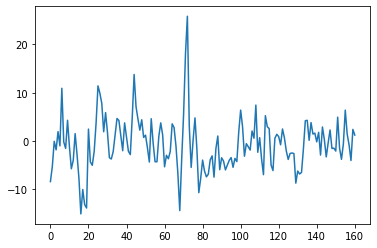

In [152]:
plt.plot(predicted)

In [150]:
output_c

'close_EMA3_G'

In [140]:
sel_input_index = df.loc[df['time'] == selected_date].index[0]
sel_input_index

0

In [141]:
selected_date

1120089600000000000

In [63]:
predicted

array([[-0.05600704]], dtype=float32)

In [64]:
selected_date

1609718400000000000

In [65]:
predicted_unnormalize

array([[-0.00067751]], dtype=float32)

In [66]:
input_c

['change', 'close_EMA3', 'Volume_rank_EMA3_EMA30_offset']

,ticker,input_c,offset,output_c,architecture,recurrent,rnnu,epoch,train_mse,train_rmse,test_mse,test_rmse,train_mean,train_std
388,PKPK,close_EMA3_G|candle_I0,1,close_EMA3_G,LSTM,30,16,50,0.134469,0.366700,0.011991,0.109505,-0.1899379304168617|-1.3177041228779305,4.989371594289146|16.596789167152075
72,PWON,change|close_EMA3|Volume_rank_EMA3_EMA30_offset,1,close_EMA3_G,GRU,20,12,30,0.179025,0.423113,0.245267,0.495244,0.001546285130190766|344.5389006340556|-0.0003...,0.0397056215861434|186.33491548946301|0.141591...
344,TURI,close_EMA3_G|Volume_EMA30_G,1,close_EMA3_G,SimpleRNN,20,24,50,0.184349,0.429359,1.618388,1.272159,0.3091625225066646|-911.4552007585985,4.567510844992979|227737.93085675413
376,POLY,close_EMA3_G,1,close_EMA3_G,LSTM,30,24,50,0.198432,0.445458,0.004931,0.070221,-0.17327778941342345,11.16598485604836
4,BUMI,close_EMA3_G|close_EMA10_G,1,close_EMA3_G,SimpleRNN,20,16,80,0.200824,0.448134,0.000871,0.029514,-0.13090100846528566|-0.14387199904726697,31.19387915233704|19.663422117803897


In [151]:
# By defining output_c and offet
selected_row = statistics_df.loc[(statistics_df['offset'] == offset) & (statistics_df['output_c'] == output_c)]
# Get input_c, recurrent, train_mean, test_mean

1609459200000000000

In [152]:
idx_df['time']

0       1120003200000000000
1       1120089600000000000
2       1120176000000000000
3       1120435200000000000
4       1120521600000000000
               ...         
3948    1632700800000000000
3949    1632787200000000000
3950    1632873600000000000
3951    1632960000000000000
3952    1633046400000000000
Name: time, Length: 3953, dtype: int64

In [4]:
tf.__version__

'2.6.0'

In [25]:
a = np.array([0,1,2,3,np.nan])
a.max()

nan

In [30]:
ticker = 'BBRI'
v15_path = './idx_indicators.db'
v15_conn = sqlite3.connect(v15_path)
v15_df = pd.read_sql(f'select * from {ticker}', v15_conn)
v15_df

,time,open,high,low,close,Volume,change,Volume_rank,rsi14,candle_I0,...,change_srp,close_rel,change_b1f3,change_b1f5,change_b1f7,change_b1f10,close_EMA3_G_s1,close_EMA3_G_s2,close_EMA10_G_s1,close_EMA10_G_s2
0,1068422400000000000,63.469437,66.491791,57.424728,58.935905,5144140000,NaN,1.000000,NaN,4.533531,...,NaN,0.000000,NaN,NaN,NaN,NaN,0.062966,0.598176,0.000000,0.000000
1,1068508800000000000,58.935909,60.447086,57.424732,60.447086,2938555000,0.025641,1.000000,NaN,-1.511177,...,0.654537,0.000316,0.076923,0.000000,0.051282,0.076923,0.598176,0.850040,0.000000,0.000000
2,1068595200000000000,58.935920,63.469452,58.935920,63.469452,2002915000,0.050000,1.000000,NaN,-4.533532,...,0.880849,0.000947,0.000000,0.000000,0.050000,0.025000,0.850040,0.550952,0.000000,0.000000
3,1068681600000000000,63.469452,63.469452,61.958274,63.469452,1190050000,0.000000,1.000000,NaN,0.000000,...,0.416314,0.000947,-0.071429,-0.023809,0.023809,0.000000,0.550952,-0.228252,0.000000,0.051889
4,1068768000000000000,63.469452,63.469452,60.447097,63.469452,1725265000,0.000000,1.000000,NaN,0.000000,...,0.416314,0.000947,-0.047619,0.000000,0.000000,-0.023809,-0.228252,-0.743785,0.051889,0.035586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,1635120000000000000,4330.000000,4370.000000,4300.000000,4300.000000,128240100,-0.022727,0.966216,64.451532,30.000000,...,0.205163,0.886266,-0.036364,NaN,NaN,NaN,-7.586616,-11.709975,19.689131,15.972925
4339,1635206400000000000,4280.000000,4370.000000,4270.000000,4350.000000,108782400,0.011628,0.958108,66.728144,-70.000000,...,0.524345,0.896715,-0.011628,NaN,NaN,NaN,-11.709975,-19.604987,15.972925,11.205120
4340,1635292800000000000,4330.000000,4340.000000,4260.000000,4290.000000,258038300,-0.013793,0.982432,61.627678,40.000000,...,0.288167,0.884177,NaN,NaN,NaN,NaN,-19.604987,-16.885827,11.205120,7.076917
4341,1635379200000000000,4210.000000,4300.000000,4200.000000,4240.000000,159645200,-0.011655,0.972973,57.671588,-30.000000,...,0.308032,0.873728,NaN,NaN,NaN,NaN,-16.885827,NaN,7.076917,NaN
